In [20]:
# install packages
!pip install ultralytics
!pip install roboflow
from ultralytics import YOLO

In [2]:
# ensure we are running on gpu
!nvidia-smi

Tue Nov 21 23:00:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# download roboflow dataset

from roboflow import Roboflow
rf = Roboflow(api_key="ifsQn3BU4lzNDypumlqe")
project = rf.workspace("national-technical-university-of-athens-icarus-team").project("trees-for-drone")
dataset = project.version(4).download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.0.215, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to trees-for-drone-4 in yolov8:: 100%|██████████| 5456/5456 [00:00<00:00, 6501.62it/s]


In [ ]:
# filter dataset
import os
import shutil

def countLines(filePath):
    with open(filePath) as f:
        lineCount = sum(1 for line in f.readlines())
    return lineCount


def copyFile(filename, filePath, destDir):
    '''copy file from filePath to destDir with same filename'''
    destFilePath = os.path.join(destDir, filename)
    shutil.copy(filePath, destFilePath)


def filter(imageSourceDir, labelSourceDir, maxBoxes, imageDestDir, labelDestDir):
    os.makedirs(imageDestDir, exist_ok=True)
    os.makedirs(labelDestDir, exist_ok=True)
    count = 0
    for (image, label) in zip(os.listdir(imageSourceDir), os.listdir(labelSourceDir)):
        imageFilePath = os.path.join(imageSourceDir, image)
        labelFilePath = os.path.join(labelSourceDir, label)
        if countLines(labelFilePath) <= maxBoxes:
            copyFile(image, imageFilePath, imageDestDir)
            copyFile(label, labelFilePath, labelDestDir)
            count += 1
    print(f'Data at {imageSourceDir} filtered, with {count} images removed')

In [ ]:
# filter train data
imageSourceDir = '/content/yolov8tree-2/train/images'
labelSourceDir = '/content/yolov8tree-2/train/labels'
imageDestDir = '/content/yolov8tree-filtered/train/images'
labelDestDir = '/content/yolov8tree-filtered/train/labels'
filter(imageSourceDir, labelSourceDir, 20, imageDestDir, labelDestDir)

# filter test data
imageSourceDir = '/content/yolov8tree-2/test/images'
labelSourceDir = '/content/yolov8tree-2/test/labels'
imageDestDir = '/content/yolov8tree-filtered/test/images'
labelDestDir = '/content/yolov8tree-filtered/test/labels'
filter(imageSourceDir, labelSourceDir, 20, imageDestDir, labelDestDir)

# filter validation data
imageSourceDir = '/content/yolov8tree-2/valid/images'
labelSourceDir = '/content/yolov8tree-2/valid/labels'
imageDestDir = '/content/yolov8tree-filtered/valid/images'
labelDestDir = '/content/yolov8tree-filtered/valid/labels'
filter(imageSourceDir, labelSourceDir, 20, imageDestDir, labelDestDir)


Data at /content/yolov8tree-2/train/images filtered, with 5681 images removed
Data at /content/yolov8tree-2/test/images filtered, with 29 images removed
Data at /content/yolov8tree-2/valid/images filtered, with 283 images removed


In [16]:
#results plotting code
import pandas as pd
import matplotlib.pyplot as plt

# Define the function to plot the data using the filepath to the CSV as the input
def plot_training_results_from_csv(filepath):
    # Read the CSV data into a pandas DataFrame
    df = pd.read_csv(filepath)

    # Set the style of the matplotlib
    plt.style.use('ggplot')

    # Define the figure size and the layout of the subplots
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 10))
    fig.suptitle('Training and Validation Metrics Over Epochs')

    # Flatten the axes array for easy iteration
    axes = axes.flatten()
    # Drop the 'epoch' column for plotting
    df_to_plot = df.drop(columns=['                  epoch'])

    # Iterate over the columns in the dataframe and create a plot for each
    for i, column in enumerate(df_to_plot.columns):
        ax = axes[i]
        ax.plot(df['                  epoch'], df_to_plot[column], label=column)
        ax.set_title(column)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Value')
        ax.legend()

    # Adjust the layout so the plots are spaced out nicely
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Call the function with a sample file path (replace 'sample_data.csv' with the actual file path)
# Please note that we don't have the actual CSV file path, so this is just a placeholder.
# plot_training_results_from_csv('sample_data.csv')

In [18]:
#logger
!load_ext tensorboard
!tensorboard --logdir /content/runs
#view results at http://localhost:6006/

/bin/bash: line 1: load_ext: command not found
2023-11-22 00:24:32.642511: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-22 00:24:32.642562: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-22 00:24:32.642588: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.14.1 at http://l

In [ ]:
!yolo task=detect mode=train model=yolov8m.pt data=/content/trees-for-drone-4/data.yaml epochs=50 imgsz=640

100% 49.7M/49.7M [00:00<00:00, 350MB/s]
Ultralytics YOLOv8.0.209 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/trees-for-drone-4/data.yaml, epochs=50, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_

In [ ]:
!yolo train resume model=/content/runs/detect/train/weights/best.pt

Ultralytics YOLOv8.0.209 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)
engine/trainer: task=detect, mode=train, model=/content/runs/detect/train/weights/best.pt, data=/content/trees-for-drone-4/data.yaml, epochs=50, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=F

In [ ]:
!yolo task=detect mode=train model=yolov8s.pt data=/content/trees-for-drone-4/data.yaml epochs=100 imgsz=640 batch=-1 box=6.5 cls=.7 dfl=1.3 momentum=0.9 lr0=0.05 lrf=0.005 dropout=0.25

Ultralytics YOLOv8.0.209 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/trees-for-drone-4/data.yaml, epochs=100, patience=50, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.25, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torch

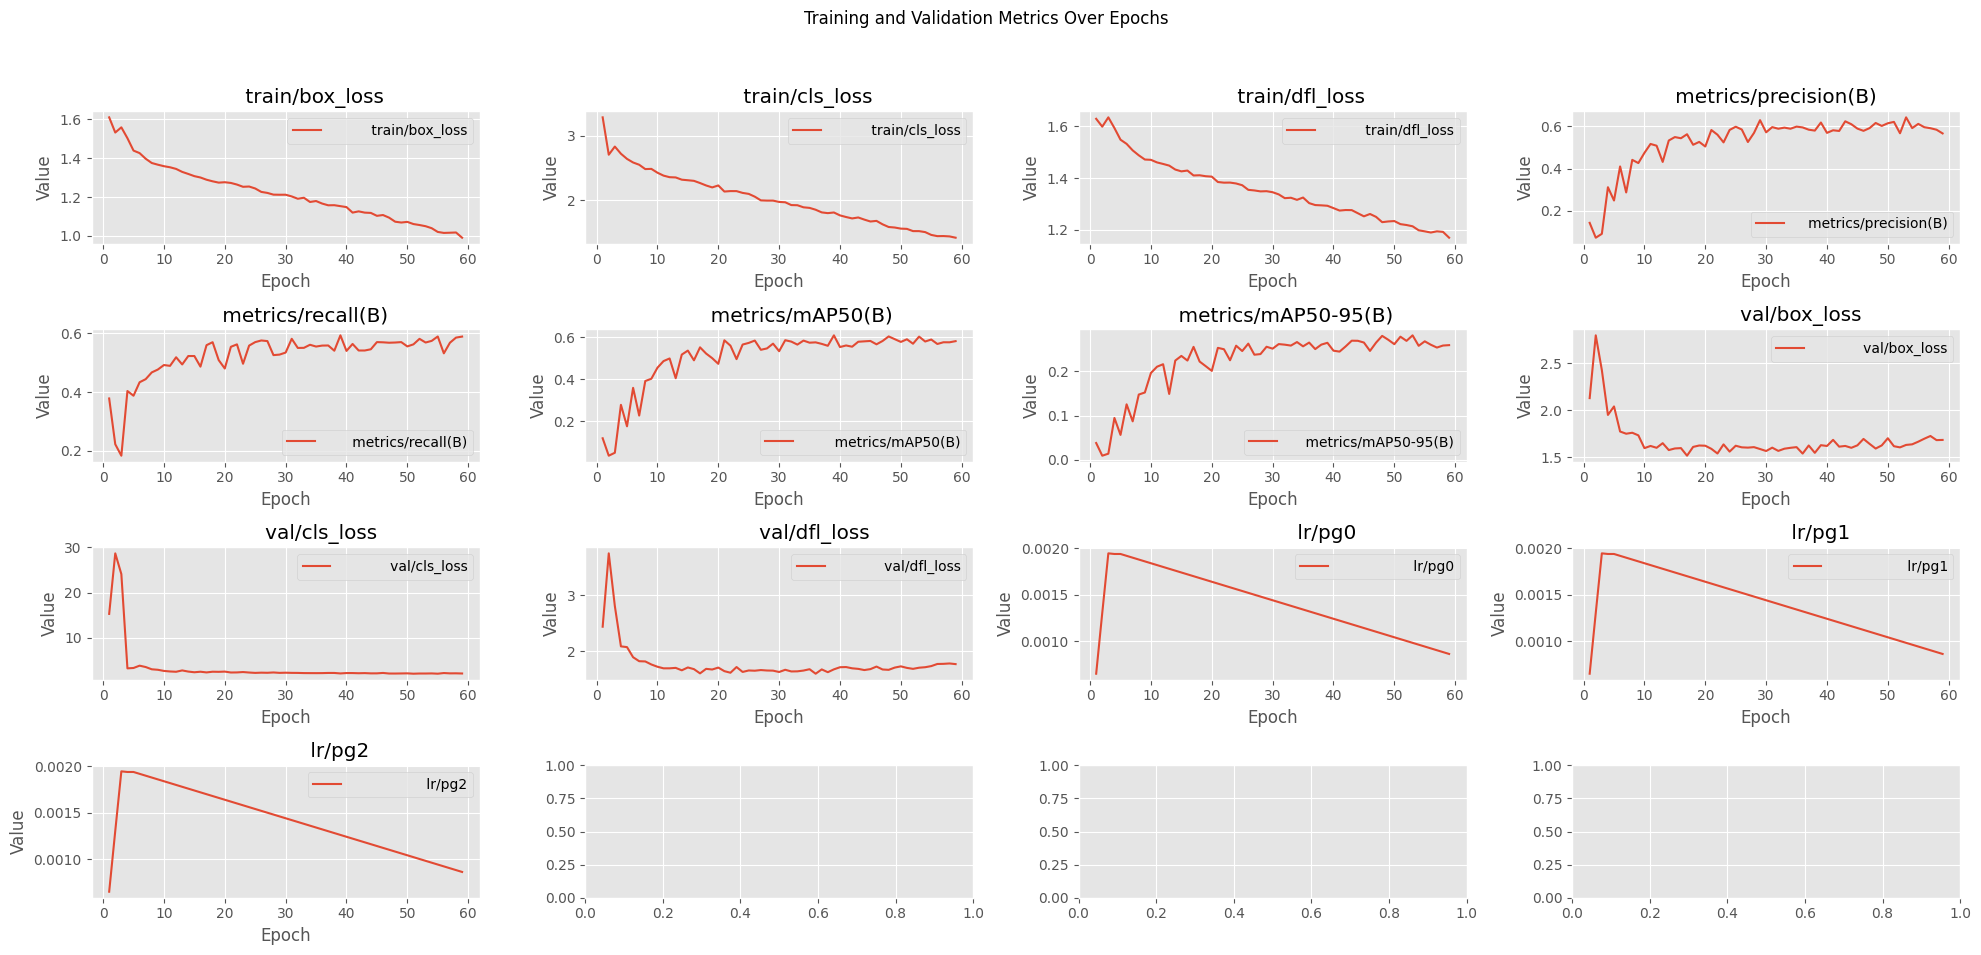

In [ ]:
plot_training_results_from_csv('/content/runs/detect/train3/results.csv')


In [5]:
!yolo task=detect mode=train model=yolov8n.pt data=/content/trees-for-drone-4/data.yaml epochs=100 imgsz=640 batch=-1

Ultralytics YOLOv8.0.215 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/trees-for-drone-4/data.yaml, epochs=100, patience=50, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras

Index(['                  epoch', '         train/box_loss',
       '         train/cls_loss', '         train/dfl_loss',
       '   metrics/precision(B)', '      metrics/recall(B)',
       '       metrics/mAP50(B)', '    metrics/mAP50-95(B)',
       '           val/box_loss', '           val/cls_loss',
       '           val/dfl_loss', '                 lr/pg0',
       '                 lr/pg1', '                 lr/pg2'],
      dtype='object')


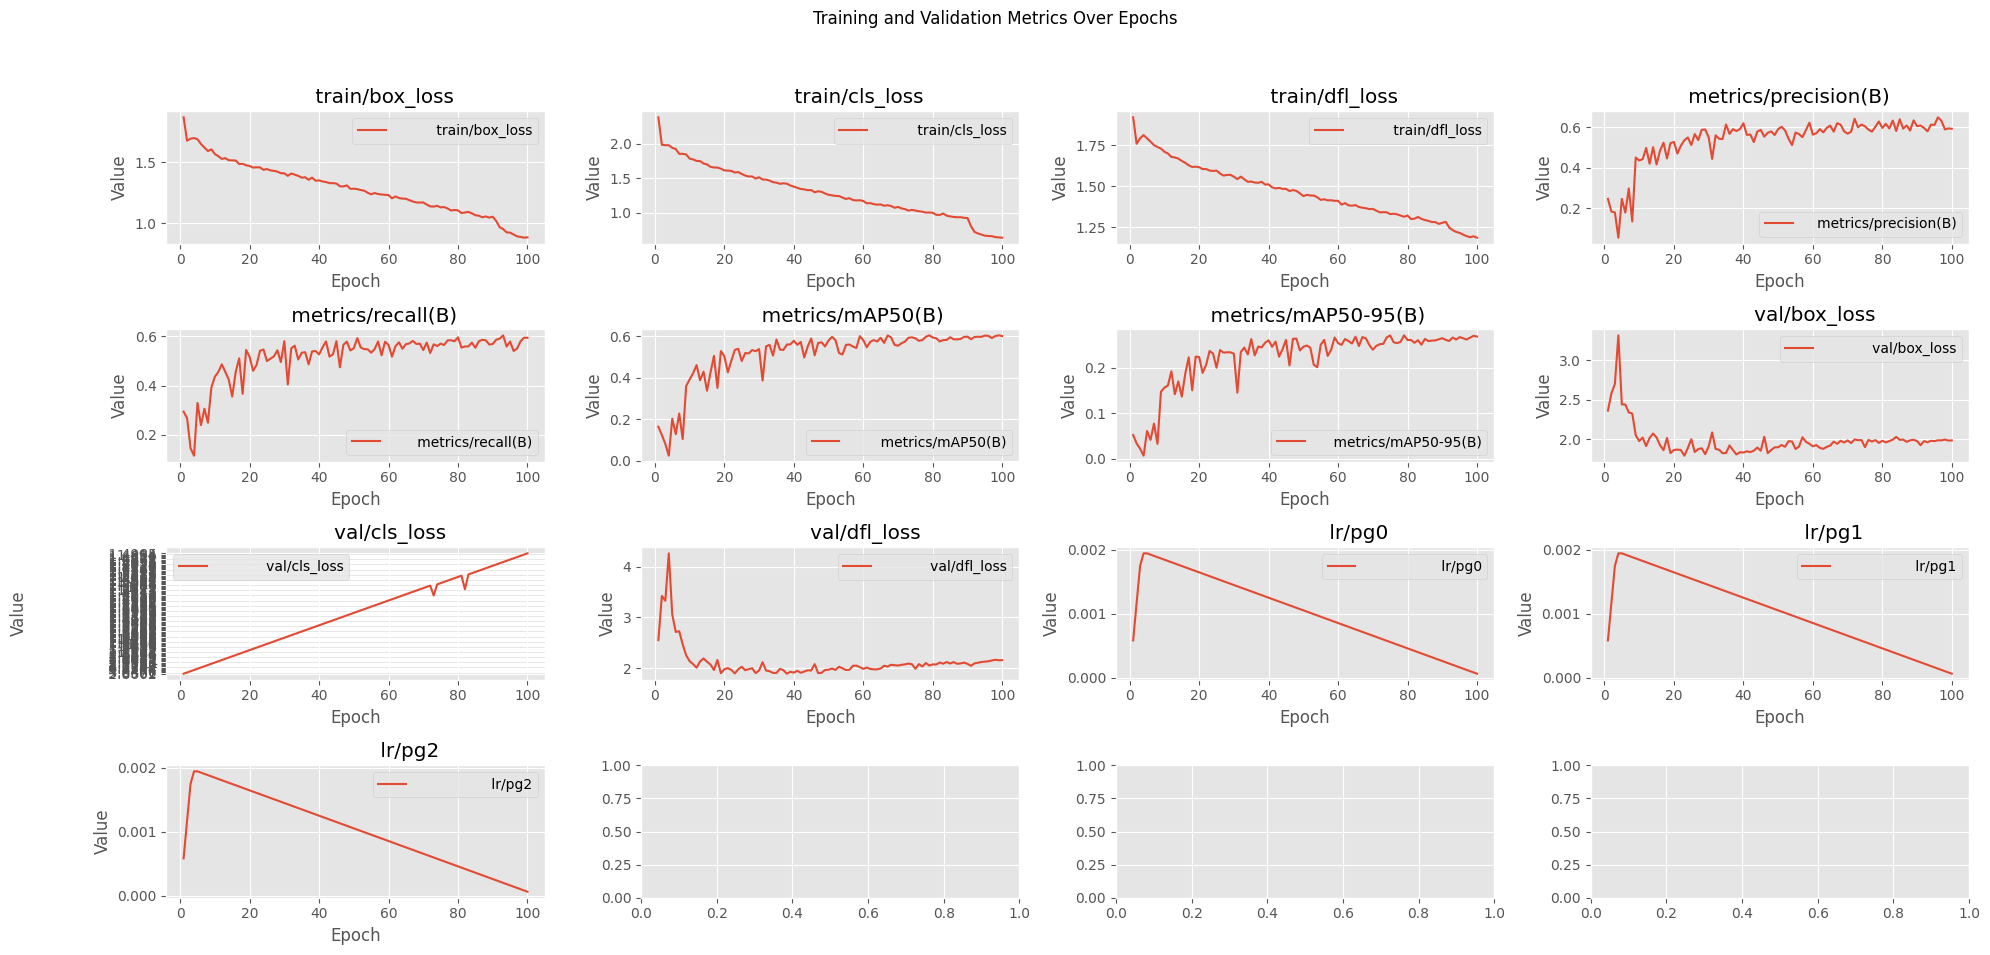

In [12]:
plot_training_results_from_csv('/content/runs/detect/train2/results.csv')

In [14]:
!yolo task=detect mode=train model=yolov8n.pt data=/content/trees-for-drone-4/data.yaml epochs=40 imgsz=640 batch=-1 single_cls=True box=6 cls=0.8 dfl=1.2 lr0=0.001 lrf=0.0001

Ultralytics YOLOv8.0.215 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/trees-for-drone-4/data.yaml, epochs=40, patience=50, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=True, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=F

Index(['                  epoch', '         train/box_loss',
       '         train/cls_loss', '         train/dfl_loss',
       '   metrics/precision(B)', '      metrics/recall(B)',
       '       metrics/mAP50(B)', '    metrics/mAP50-95(B)',
       '           val/box_loss', '           val/cls_loss',
       '           val/dfl_loss', '                 lr/pg0',
       '                 lr/pg1', '                 lr/pg2'],
      dtype='object')


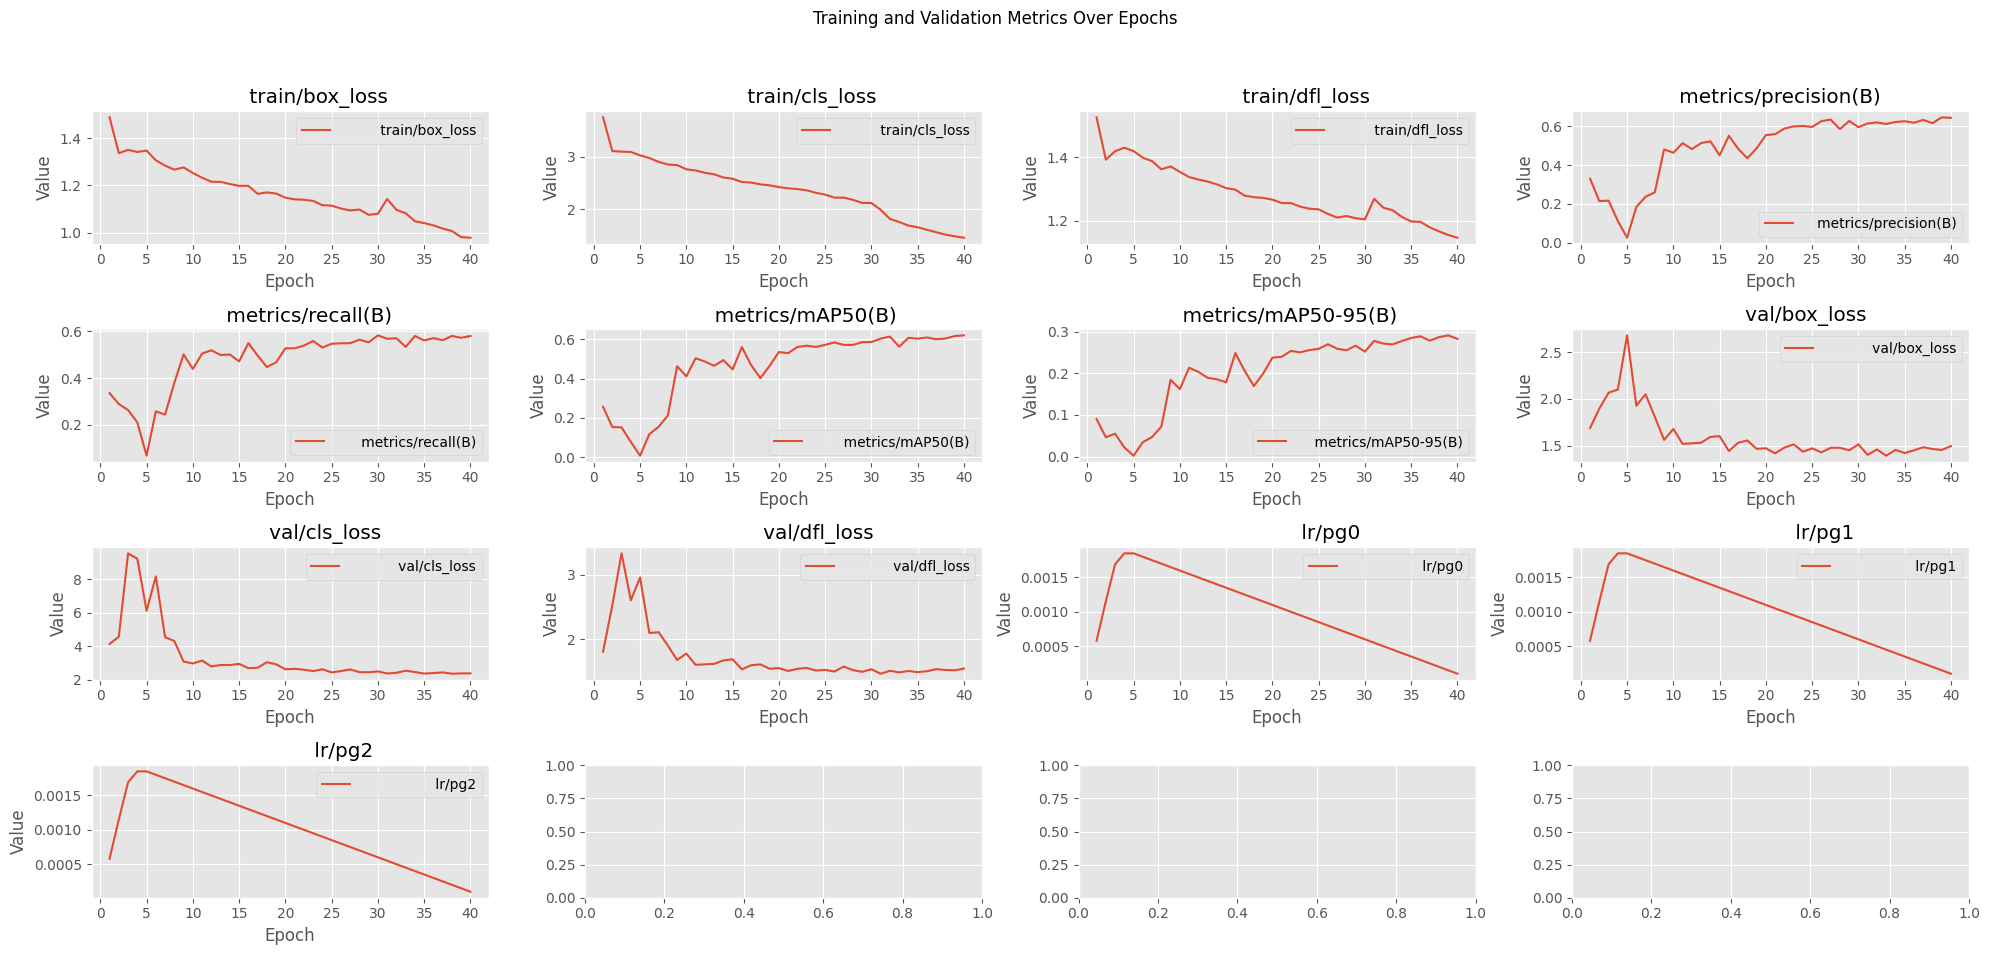

In [15]:
plot_training_results_from_csv('/content/runs/detect/train4/results.csv')

In [22]:
!yolo task=detect mode=train model=yolov8n.pt data=/content/trees-for-drone-4/data.yaml epochs=400 imgsz=640 batch=-1 single_cls=True box=5 cls=0.8 dfl=1.2 lr0=0.001 lrf=0.0001

Ultralytics YOLOv8.0.215 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/trees-for-drone-4/data.yaml, epochs=400, patience=50, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=True, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=